### Import packages

In [15]:
import os
import sys
import warnings

import datetime
import math
import numpy as np
import pandas as pd
import platform
import re
import subprocess
import torch as th

import os
import pickle

import gymnasium as gym
import matplotlib.pyplot as plt

from datetime import datetime
from scripts.utils import *
from scripts.visualizations import *
from src.config import *
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.logger import configure  # Import the configure function
from stable_baselines3.common.utils import polyak_update, set_random_seed
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv

from scripts.utils import NumpyEncoder
from scripts.logger import *

import json


### Hyperparameters


In [16]:
# Constants and Training Settings
LEARNING_RATE = 0.001
GAMMA = 0.99
BUFFER_SIZE = 100000
BATCH_SIZE = 256
TARGET_UPDATE_INTERVAL = 100
MAX_TIMESTEPS = 50000

NEURAL_NET_STRUCTURE = dict(net_arch=[256, 512, 512, 256])
LEARNING_STARTS = 1000
TRAIN_FREQ = 4

EPSILON_START = 1.0
EPSILON_MIN = 0.025
PERCENTAGE_MIN = 90
# EXPLORATION_PHASE = 1000


EPSILON_TYPE = "exponential"
# EPSILON_TYPE = "linear"


if EPSILON_TYPE == "linear":
    EPSILON_MIN = 0

N_EPISODES = 50
cross_val_flag = False
CROSS_VAL_INTERVAL = N_EPISODES/50

# TRAINING_FOLDERS_PATH = "../data/Locked/alpha/"
# TRAINING_FOLDERS_PATH = "../data/Training/3ac-10/"
# TRAINING_FOLDERS_PATH = "../data/Training/temp/"
TRAINING_FOLDERS_PATH = "../data/Training/3ac-10-deterministic/"
TESTING_FOLDERS_PATH = "../data/Training/3ac-100/"


# extract number of scenarios in training and testing folders
num_scenarios_training = len(os.listdir(TRAINING_FOLDERS_PATH))
exploration_phase_percentage = 5
num_timesteps_per_scenario = 5

total_timesteps = N_EPISODES * num_scenarios_training * num_timesteps_per_scenario
EXPLORATION_PHASE = int(exploration_phase_percentage / 100 * total_timesteps)
print(f"Exploration phase: {EXPLORATION_PHASE} timesteps")

print(f"Total timesteps: {total_timesteps}")


Exploration phase: 125 timesteps
Total timesteps: 2500


## ESTIMATED VALUES

Calculating...
Estimated total timesteps:  3200.0
Calculated EPSILON_DECAY_RATE: 0.001280860921567339

Testing...
Epsilon reaches its minimum value at 89.94% of total timesteps.


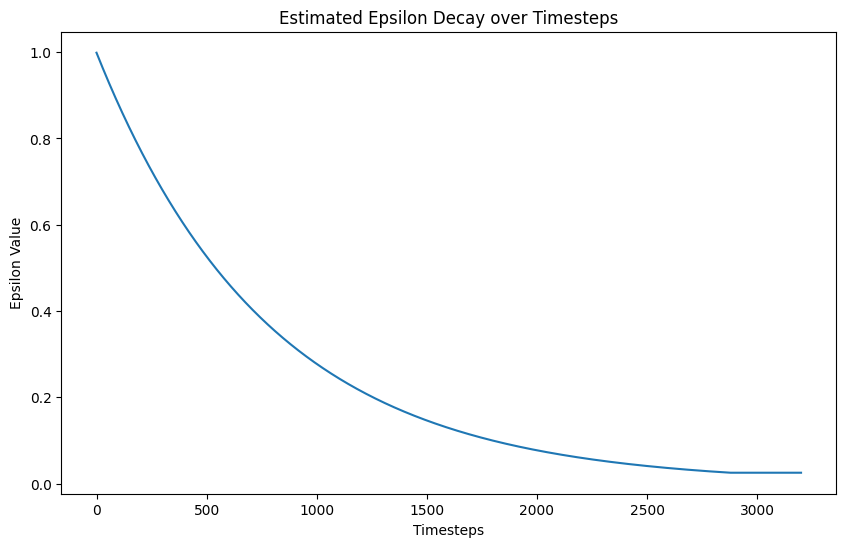

EPSILON DECAY RATE:  0.001280860921567339


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from src.environment import AircraftDisruptionEnv

print("Calculating...")
# Calculate total timesteps 10 times and take the average
total_timesteps_list = [calculate_total_training_timesteps(TRAINING_FOLDERS_PATH, N_EPISODES) for _ in range(1)]
estimated_total_timesteps = sum(total_timesteps_list) / len(total_timesteps_list)

print("Estimated total timesteps: ", estimated_total_timesteps)

# Calculate the decay rate or linear rate
EPSILON_DECAY_RATE = calculate_epsilon_decay_rate(
    estimated_total_timesteps,
    EPSILON_START,
    EPSILON_MIN,
    PERCENTAGE_MIN,
    EPSILON_TYPE
)

print("")
print("Testing...")
simulate_and_plot_epsilon_decay(
    EPSILON_START, EPSILON_MIN, EPSILON_DECAY_RATE, estimated_total_timesteps, EPSILON_TYPE
)

EPSILON_DECAY_RATE = EPSILON_DECAY_RATE
print("EPSILON DECAY RATE: ", EPSILON_DECAY_RATE)


In [4]:
# Initialize device
device = initialize_device()

# Check device capabilities
check_device_capabilities()

# Get device-specific information
device_info = get_device_info(device)
print(f"Device info: {device_info}")

# Verify training folders and gather training data
training_folders = verify_training_folders(TRAINING_FOLDERS_PATH)
# print(f"Training folders: {training_folders}")

# Calculate training days and model naming
num_days_trained_on = calculate_training_days(N_EPISODES, training_folders)
print(f"Training on {num_days_trained_on} days of data "
        f"({N_EPISODES} episodes of {len(training_folders)} scenarios)")

formatted_days = format_days(num_days_trained_on)
MODEL_SAVE_PATH = f'../trained_models/dqn/'

# myopic_model_name = "myopic_3ac"
# proactive_model_name = "proactive_3ac"
# myopic_model_version = get_model_version(myopic_model_name, myopic_proactive="myopic", drl_type="dqn")
# proactive_model_version = get_model_version(proactive_model_name, myopic_proactive="proactive", drl_type="dqn")

# myopic_model_path = f"{MODEL_SAVE_PATH}{myopic_model_name}-{myopic_model_version}.zip"
# proactive_model_path = f"{MODEL_SAVE_PATH}{proactive_model_name}-{proactive_model_version}.zip"
# print(f"Models will be saved to:")
# print(f"   {myopic_model_path}")
# print(f"   {proactive_model_path}")

# Create results directory
results_dir = create_results_directory(append_to_name='dqn')
print(f"Results directory created at: {results_dir}")








Using device: mps
CUDA available: False
Number of GPUs available: 0
cuDNN enabled: True
Device: mps
Using MacBook M1
Device info: {'device_type': 'MacBook M1'}
Training on 10000 days of data (1000 episodes of 10 scenarios)
Results directory created at: ../results/dqn/20241205-20-41


# Reinforcement Learning

## Training

In [5]:
from scripts.logger import create_new_id, get_config_variables
import src.config as config

# Training both agents: myopic and proactive

def train_dqn_agent(env_type):
    log_data = {}  # Main dictionary to store all logs

    config_variables = get_config_variables(config)

    # Generate unique ID for training
    training_id = create_new_id("training")
    runtime_start_in_seconds = time.time()

    if env_type == "myopic":
        model_path = f"../trained_models/dqn/myopic-{training_id}.zip"
        print(f"Models will be saved to: {model_path}")
        model_path_and_name = model_path
    elif env_type == "proactive":
        model_path = f"../trained_models/dqn/proactive-{training_id}.zip"
        print(f"Models will be saved to: {model_path}")
        model_path_and_name = model_path
    # Metadata for logging
    training_metadata = {
        "myopic_or_proactive": env_type,
        "model_type": "dqn",
        "training_id": training_id,
        "MODEL_SAVE_PATH": model_path,
        "N_EPISODES": N_EPISODES,
        "num_scenarios_training": num_scenarios_training,
        "results_dir": results_dir,
        "CROSS_VAL_FLAG": cross_val_flag,
        "CROSS_VAL_INTERVAL": CROSS_VAL_INTERVAL,
        **config_variables,
        "LEARNING_RATE": LEARNING_RATE,
        "GAMMA": GAMMA,
        "BUFFER_SIZE": BUFFER_SIZE,
        "BATCH_SIZE": BATCH_SIZE,
        "TARGET_UPDATE_INTERVAL": TARGET_UPDATE_INTERVAL,
        "EPSILON_START": EPSILON_START,
        "EPSILON_MIN": EPSILON_MIN,
        "EPSILON_DECAY_RATE": EPSILON_DECAY_RATE,
        "EXPLORATION_PHASE": EXPLORATION_PHASE,
        "MAX_TIMESTEPS": MAX_TIMESTEPS,
        "LEARNING_STARTS": LEARNING_STARTS,
        "TRAIN_FREQ": TRAIN_FREQ,
        "NEURAL_NET_STRUCTURE": NEURAL_NET_STRUCTURE,
        "device_info": str(get_device_info(device)),
        "TRAINING_FOLDERS_PATH": TRAINING_FOLDERS_PATH,
        "TESTING_FOLDERS_PATH": TESTING_FOLDERS_PATH,
        "runtime_start": datetime.utcnow().isoformat() + "Z",
        "runtime_start_in_seconds": runtime_start_in_seconds,
    }

    log_data['metadata'] = training_metadata
    log_data['episodes'] = {}
    log_data['cross_validation'] = {}

    best_reward_avg = float('-inf')
    # Initialize variables
    rewards = {}
    good_rewards = {}
    test_rewards = []
    epsilon_values = []
    total_timesteps = 0  # Added to track total timesteps
    consecutive_drops = 0  # Track consecutive performance drops
    best_test_reward = float('-inf')  # Track best test performance
    action_sequences = {
        os.path.join(TRAINING_FOLDERS_PATH, folder): {
            "best_actions": [],
            "best_reward": float('-inf'),
            "worst_actions": [],
            "worst_reward": float('inf')
        }
        for folder in training_folders
    }
    
    def cross_validate_on_test_data(model, current_episode, log_data):
        cross_val_data = {
            "episode": current_episode,
            "scenarios": [],
            "avg_test_reward": 0,
        }

        test_scenario_folders = [
            os.path.join(TESTING_FOLDERS_PATH, folder)
            for folder in os.listdir(TESTING_FOLDERS_PATH)
            if os.path.isdir(os.path.join(TESTING_FOLDERS_PATH, folder))
        ]
        total_test_reward = 0
        for test_scenario_folder in test_scenario_folders:
            scenario_data = {
                "scenario_folder": test_scenario_folder,
                "total_reward": 0,
                "steps": []
            }
            # Load data
            data_dict = load_scenario_data(test_scenario_folder)
            aircraft_dict = data_dict['aircraft']
            flights_dict = data_dict['flights']
            rotations_dict = data_dict['rotations']
            alt_aircraft_dict = data_dict['alt_aircraft']
            config_dict = data_dict['config']

            # Update the environment with the new scenario (by reinitializing it)
            from src.environment import AircraftDisruptionEnv
            env = AircraftDisruptionEnv(
                aircraft_dict,
                flights_dict,
                rotations_dict,
                alt_aircraft_dict,
                config_dict,
                env_type=env_type
            )
            model.set_env(env)  # Update the model's environment with the new instance

            # Evaluate the model on the test scenario without training
            obs, _ = env.reset()

            done_flag = False
            total_reward = 0
            timesteps = 0

            while not done_flag and timesteps < MAX_TIMESTEPS:
                # Get the action mask from the environment
                action_mask = obs['action_mask']

                # Convert observation to float32
                obs = {key: np.array(value, dtype=np.float32) for key, value in obs.items()}

                # Preprocess observation and get Q-values
                obs_tensor = model.policy.obs_to_tensor(obs)[0]
                q_values = model.policy.q_net(obs_tensor).detach().cpu().numpy().squeeze()

                # Apply the action mask (set invalid actions to -np.inf)
                masked_q_values = q_values.copy()
                masked_q_values[action_mask == 0] = -np.inf

                # Select the action with the highest masked Q-value
                action = np.argmax(masked_q_values)

                # Take the selected action in the environment
                result = env.step(action)

                # Unpack the result
                obs_next, reward, terminated, truncated, info = result

                done_flag = terminated or truncated

                # Accumulate the reward
                total_reward += reward

                # Update the current observation
                obs = obs_next

                scenario_data["steps"].append({
                    "step_number": timesteps + 1,
                    "action": action,
                    "flight_action": env.map_index_to_action(action)[0],
                    "aircraft_action": env.map_index_to_action(action)[1],
                    "reward": reward,
                    "total_timestep": total_timesteps,
                    "time_in_scenario": timesteps,
                    "epsilon": "1.0 at cross-validation",
                    "action_reason": "exploitation at cross-validation",
                    "action_mask": action_mask,
                    "action_mask_sum": np.sum(action_mask),
                    "len_action_mask": len(action_mask),
                    "masked_q_values": masked_q_values,
                    "q_values": q_values,
                    "info_after_step": env.info_after_step,
                    # Assuming impact_of_action is defined elsewhere
                    # "impact_of_action": impact_of_action,
                })

                timesteps += 1
                if done_flag:
                    break

            total_test_reward += total_reward

            scenario_data["total_reward"] = total_reward
            cross_val_data["scenarios"].append(scenario_data)

        # Compute average test reward
        avg_test_reward = total_test_reward / len(test_scenario_folders)
        cross_val_data["avg_test_reward"] = avg_test_reward
        test_rewards.append((current_episode, avg_test_reward))
        print(f"cross-val done at episode {current_episode}")

        # Store cross-validation data in log_data
        log_data['cross_validation'][current_episode] = cross_val_data

        return avg_test_reward  # Return the average test reward

    # List all the scenario folders in Data/Training
    scenario_folders = [
        os.path.join(TRAINING_FOLDERS_PATH, folder)
        for folder in os.listdir(TRAINING_FOLDERS_PATH)
        if os.path.isdir(os.path.join(TRAINING_FOLDERS_PATH, folder))
    ]

    epsilon = EPSILON_START
    total_timesteps = 0  # Reset total_timesteps for each agent

    # Initialize the DQN
    dummy_scenario_folder = scenario_folders[0]
    data_dict = load_scenario_data(dummy_scenario_folder)
    aircraft_dict = data_dict['aircraft']
    flights_dict = data_dict['flights']
    rotations_dict = data_dict['rotations']
    alt_aircraft_dict = data_dict['alt_aircraft']
    config_dict = data_dict['config']

    from src.environment import AircraftDisruptionEnv

    env = AircraftDisruptionEnv(
        aircraft_dict,
        flights_dict,
        rotations_dict,
        alt_aircraft_dict,
        config_dict,
        env_type=env_type
    )

    model = DQN(
        policy='MultiInputPolicy',
        env=env,
        learning_rate=LEARNING_RATE,
        gamma=GAMMA,
        buffer_size=BUFFER_SIZE,
        learning_starts=LEARNING_STARTS,
        batch_size=BATCH_SIZE,
        target_update_interval=TARGET_UPDATE_INTERVAL,
        verbose=0,
        policy_kwargs=NEURAL_NET_STRUCTURE,
        device=device
    )

    logger = configure()
    model._logger = logger

    # Training loop over the number of episodes
    for episode in range(N_EPISODES):
        # create a dictionary in the rewards dictionary for the current episode
        rewards[episode] = {}
        # create a dictionary in the action_sequences dictionary for the current episode
        action_sequences[episode] = {}
        # Log the start of the episode
        episode_data = {
            "episode_number": episode + 1,
            "epsilon_start": epsilon,
            "scenarios": {},
        }
        # Cycle through all the scenario folders
        for scenario_folder in scenario_folders:
            scenario_data = {
                "scenario_folder": scenario_folder,
                "steps": [],
                "total_reward": 0,
            }
            # create a dictionary in the rewards dictionary for the current scenario
            rewards[episode][scenario_folder] = {}
            # create a dictionary in the action_sequences dictionary for the current scenario
            action_sequences[episode][scenario_folder] = []
            best_reward = float('-inf')
            best_action_sequence = []
            # Load the data for the current scenario
            data_dict = load_scenario_data(scenario_folder)
            aircraft_dict = data_dict['aircraft']
            flights_dict = data_dict['flights']
            rotations_dict = data_dict['rotations']
            alt_aircraft_dict = data_dict['alt_aircraft']
            config_dict = data_dict['config']

            # Update the environment with the new scenario (by reinitializing it)
            env = AircraftDisruptionEnv(
                aircraft_dict,
                flights_dict,
                rotations_dict,
                alt_aircraft_dict,
                config_dict,
                env_type=env_type
            )
            model.set_env(env)  # Update the model's environment with the new instance

            # Reset the environment
            obs, _ = env.reset()  # Extract the observation (obs) and ignore the info (_)

            done_flag = False
            total_reward = 0
            timesteps = 0
            action_sequence = []

            while not done_flag and timesteps < MAX_TIMESTEPS:

                # Get cancelled flights
                num_cancelled_flights_before_step = len(env.cancelled_flights)  # Returns a set of flight IDs

                # Get delayed flights and their delays (in minutes)
                num_delayed_flights_before_step = len(env.environment_delayed_flights)  # Returns a dict of {flight_id: delay_minutes}

                # Get flights that have already been penalized for delays
                num_penalized_delays_before_step = len(env.penalized_delays)  # Returns a dict of {flight_id: delay_minutes}

                # Get flights that have already been penalized for being cancelled
                num_penalized_cancelled_before_step = len(env.penalized_cancelled_flights)  # Returns a set of flight IDs

                model.exploration_rate = epsilon

                # Get the action mask from the environment
                action_mask = obs['action_mask']

                # Convert observation to float32
                obs = {key: np.array(value, dtype=np.float32) for key, value in obs.items()}

                # Preprocess observation and get Q-values
                obs_tensor = model.policy.obs_to_tensor(obs)[0]
                q_values = model.policy.q_net(obs_tensor).detach().cpu().numpy().squeeze()

                # Apply the action mask (set invalid actions to -np.inf)
                masked_q_values = q_values.copy()
                masked_q_values[action_mask == 0] = -np.inf

                current_seed = int(time.time() * 1e9) % (2**32 - 1)
                # print(current_seed)
                np.random.seed(current_seed)
                
                brute_force_flag = False
                # Select an action
                action_reason = "None"
                if np.random.rand() < epsilon or brute_force_flag:
                    # Exploration: choose a random valid action
                    valid_actions = np.where(action_mask == 1)[0]
                    action = np.random.choice(valid_actions)
                    action_reason = "exploration"
                else:
                    # Exploitation: choose the action with the highest masked Q-value
                    action = np.argmax(masked_q_values)
                    action_reason = "exploitation"

                # Take the selected action in the environment
                result = env.step(action)

                # Unpack the result (5 values)
                obs_next, reward, terminated, truncated, info = result

                # Store the reward for the current timestep
                rewards[episode][scenario_folder][timesteps] = reward
                action_sequences[episode][scenario_folder].append(action)

                # Combine the terminated and truncated flags into a single done flag
                done_flag = terminated or truncated

                # Store the action
                action_sequence.append(action)

                # Add the transition to the replay buffer
                model.replay_buffer.add(
                    obs=obs,
                    next_obs=obs_next,
                    action=action,
                    reward=reward,
                    done=done_flag,
                    infos=[info]
                )

                # Update the current observation
                obs = obs_next

                if total_timesteps < EXPLORATION_PHASE:
                    # Hold epsilon at 1 during the exploration phase
                    epsilon = EPSILON_START
                else:
                    # Update epsilon after the exploration phase
                    epsilon = max(EPSILON_MIN, epsilon * (1 - EPSILON_DECAY_RATE))
                    
                epsilon_values.append((episode + 1, epsilon))

                timesteps += 1
                total_timesteps += 1  # Update total_timesteps

                # Training
                if total_timesteps > model.learning_starts and total_timesteps % TRAIN_FREQ == 0:
                    # Perform a training step
                    model.train(gradient_steps=1, batch_size=BATCH_SIZE)

                # Update target network
                if total_timesteps % model.target_update_interval == 0:
                    polyak_update(model.q_net.parameters(), model.q_net_target.parameters(), model.tau)
                    # Copy batch norm stats
                    polyak_update(model.batch_norm_stats, model.batch_norm_stats_target, 1.0)

                num_cancelled_flights_after_step = len(env.cancelled_flights)
                num_delayed_flights_after_step = len(env.environment_delayed_flights)
                num_penalized_delays_after_step = len(env.penalized_delays)
                num_penalized_cancelled_after_step = len(env.penalized_cancelled_flights)

                impact_of_action = {
                    "num_cancelled_flights": num_cancelled_flights_after_step - num_cancelled_flights_before_step,
                    "num_delayed_flights": num_delayed_flights_after_step - num_delayed_flights_before_step,
                    "num_penalized_delays": num_penalized_delays_after_step - num_penalized_delays_before_step,
                    "num_penalized_cancelled": num_penalized_cancelled_after_step - num_penalized_cancelled_before_step,
                }

                scenario_data["steps"].append({
                    "step_number": timesteps,
                    "action": action,
                    "flight_action": env.map_index_to_action(action)[0],
                    "aircraft_action": env.map_index_to_action(action)[1],
                    "reward": reward,
                    "total_timestep": total_timesteps,
                    "time_in_scenario": timesteps,
                    "epsilon": epsilon,
                    "action_reason": action_reason,
                    "impact_of_action": impact_of_action,
                    "done_flag": done_flag,
                    "action_mask_sum": np.sum(action_mask),
                    "len_action_mask": len(action_mask),
                    "info_after_step": env.info_after_step,
                    "masked_q_values": masked_q_values,
                    "q_values": q_values,
                    "action_mask": action_mask,
                })
                
                # Check if the episode is done
                if done_flag:
                    break
            
            total_reward = 0
            for _, reward in rewards[episode][scenario_folder].items():
                total_reward += reward
            # Store the total reward for the episode with the scenario specified
            rewards[episode][scenario_folder] = total_reward

            # save the action sequence
            action_sequences[episode][scenario_folder] = action_sequence

            # Summarize scenario
            scenario_data["total_reward"] = total_reward
            episode_data["scenarios"][scenario_folder] = scenario_data

        # Perform cross-validation at specified intervals
        if cross_val_flag:
            # Initialize best_test_reward and current_test_reward at first cross validation
            if (episode + 1) % CROSS_VAL_INTERVAL == 0:
                current_test_reward = cross_validate_on_test_data(model, episode + 1, log_data)
                if not hasattr(train_dqn_agent, 'best_test_reward'):
                    train_dqn_agent.best_test_reward = current_test_reward
                best_test_reward = train_dqn_agent.best_test_reward
            
                # Early stopping logic
                if current_test_reward < best_test_reward:
                    consecutive_drops += 1
                    print(f"Performance drop {consecutive_drops}/5 (current: {current_test_reward:.2f}, best: {best_test_reward:.2f})")
                    if consecutive_drops >= 500:
                        print(f"Early stopping triggered at episode {episode + 1} due to 5 consecutive drops in test performance")
                        break
                else:
                    consecutive_drops = 0
                    train_dqn_agent.best_test_reward = current_test_reward
                    best_test_reward = current_test_reward

        # Calculate the average reward for this batch of episodes
        avg_reward_for_this_batch = 0
        for i in range(len(scenario_folders)):
            avg_reward_for_this_batch += rewards[episode][scenario_folders[i]]
        avg_reward_for_this_batch /= len(scenario_folders)

        # Append the avg reward for this batch to rewards
        rewards[episode + 1] = avg_reward_for_this_batch

        good_rewards[episode + 1] = avg_reward_for_this_batch
        if avg_reward_for_this_batch > best_reward_avg:
            best_reward_avg = avg_reward_for_this_batch
        print(f"{env_type}: ({episode + 1}/{N_EPISODES}) {epsilon:.2f} best avg: {best_reward_avg:.2f} - rewards avg: {avg_reward_for_this_batch:.2f}")
        # print(f"Total avg rewards for this batch: {avg_reward_for_this_batch}")

        # Summarize episode
        episode_data["avg_reward"] = avg_reward_for_this_batch
        log_data['episodes'][episode + 1] = episode_data

    # Save the model after training
    if env_type == "myopic":
        model.save(f"../trained_models/dqn/myopic-{training_id}.zip")
    else:
        model.save(f"../trained_models/dqn/proactive-{training_id}.zip")

    runtime_end_in_seconds = time.time()
    runtime_in_seconds = runtime_end_in_seconds - runtime_start_in_seconds

    actual_total_timesteps = total_timesteps
    actual_exploration_timesteps = EXPLORATION_PHASE
    actual_exploration_percentage = actual_exploration_timesteps / total_timesteps
    actual_exploitation_timesteps = total_timesteps - EXPLORATION_PHASE

    training_summary = {
        "runtime_seconds": runtime_in_seconds,
        "total_timesteps": total_timesteps,
        "final_rewards": good_rewards,
        "episodes_trained": episode + 1,
        "actual_total_timesteps": actual_total_timesteps,
        "actual_exploration_timesteps": actual_exploration_timesteps,
        "actual_exploration_percentage": actual_exploration_percentage,
        "actual_exploitation_timesteps": actual_exploitation_timesteps,
    }
    log_data['training_summary'] = training_summary

    # Include all other relevant data
    log_data['average_batch_episode_rewards'] = good_rewards
    log_data['test_rewards'] = test_rewards
    log_data['epsilon_values'] = epsilon_values
    log_data['action_sequences'] = action_sequences
    log_data['rewards'] = rewards

    # Write all data to the log file at once
    log_file_path = os.path.join("../logs", "training", f"training_{training_id}.json")
    
    # make log_data serializable
    log_data = convert_to_serializable(log_data)
    with open(log_file_path, 'w') as log_file:
        json.dump(log_data, log_file, indent=4, cls=NumpyEncoder)


    finalize_training_log(training_id, training_summary, model_path)

    # Return collected data
    return rewards, test_rewards, total_timesteps, epsilon_values, good_rewards, action_sequences, model_path_and_name


In [6]:

# Main code to train both agents and plot results
start_time = datetime.now()

# Train the myopic DQN agents
results_myopic = train_dqn_agent('myopic')

# Unpack the results
rewards_myopic, test_rewards_myopic, total_timesteps_myopic, epsilon_values_myopic, good_rewards_myopic, action_sequences_myopic, model_path_and_name_myopic = results_myopic


# Save the myopic rewards and good rewards
myopic_rewards_file = os.path.join(results_dir, "rewards_myopic.pkl")
good_rewards_file = os.path.join(results_dir, "good_rewards_myopic.pkl")
with open(myopic_rewards_file, "wb") as file:
    pickle.dump(rewards_myopic, file)
with open(good_rewards_file, "wb") as file:
    pickle.dump(good_rewards_myopic, file)

print(f"Myopic rewards saved to {myopic_rewards_file}")
print(f"Good rewards saved to {good_rewards_file}")
print(f"Myopic model saved to \n{model_path_and_name_myopic}")

Models will be saved to: ../trained_models/dqn/myopic-0313.zip
Device: mps
Using MacBook M1
Logging to /var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/SB3-2024-12-05-20-41-37-504470
myopic: (1/1000) 1.00 best avg: 4567.90 - rewards avg: 4567.90
myopic: (2/1000) 1.00 best avg: 4567.90 - rewards avg: -1524.94
myopic: (3/1000) 1.00 best avg: 4567.90 - rewards avg: -5360.96
myopic: (4/1000) 1.00 best avg: 4567.90 - rewards avg: -4971.60
myopic: (5/1000) 1.00 best avg: 4567.90 - rewards avg: -8309.06
myopic: (6/1000) 1.00 best avg: 4567.90 - rewards avg: -786.61
myopic: (7/1000) 1.00 best avg: 4567.90 - rewards avg: 210.40
myopic: (8/1000) 1.00 best avg: 4567.90 - rewards avg: -4126.70
myopic: (9/1000) 1.00 best avg: 4567.90 - rewards avg: -2276.69
myopic: (10/1000) 1.00 best avg: 4567.90 - rewards avg: -4220.58
myopic: (11/1000) 1.00 best avg: 4567.90 - rewards avg: -4616.48
myopic: (12/1000) 1.00 best avg: 4567.90 - rewards avg: 1366.91
myopic: (13/1000) 1.00 best avg: 5149.82 - rewards 

In [7]:


results_proactive = train_dqn_agent('proactive')

# Unpack the results
rewards_proactive, test_rewards_proactive, total_timesteps_proactive, epsilon_values_proactive, good_rewards_proactive, action_sequences_proactive, model_path_and_name_proactive = results_proactive

# Save the proactive rewards and good rewards
proactive_rewards_file = os.path.join(results_dir, "rewards_proactive.pkl")
good_rewards_file = os.path.join(results_dir, "good_rewards_proactive.pkl")
with open(proactive_rewards_file, "wb") as file:
    pickle.dump(rewards_proactive, file)
with open(good_rewards_file, "wb") as file:
    pickle.dump(good_rewards_proactive, file)
print(f"Proactive rewards saved to {proactive_rewards_file}")




end_time = datetime.now()
runtime = end_time - start_time
runtime_in_seconds = runtime.total_seconds()

print(good_rewards_myopic)
print(good_rewards_proactive)

Models will be saved to: ../trained_models/dqn/proactive-0314.zip
Device: mps
Using MacBook M1
Logging to /var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/SB3-2024-12-05-20-44-34-852171
proactive: (1/1000) 1.00 best avg: -6847.99 - rewards avg: -6847.99
proactive: (2/1000) 1.00 best avg: -5219.53 - rewards avg: -5219.53
proactive: (3/1000) 1.00 best avg: -5219.53 - rewards avg: -11679.68
proactive: (4/1000) 1.00 best avg: -5219.53 - rewards avg: -8402.35
proactive: (5/1000) 1.00 best avg: -3806.27 - rewards avg: -3806.27
proactive: (6/1000) 1.00 best avg: 2167.81 - rewards avg: 2167.81
proactive: (7/1000) 1.00 best avg: 2167.81 - rewards avg: -8980.96
proactive: (8/1000) 1.00 best avg: 3449.79 - rewards avg: 3449.79
proactive: (9/1000) 1.00 best avg: 3449.79 - rewards avg: -7678.55
proactive: (10/1000) 1.00 best avg: 3449.79 - rewards avg: -9423.56
proactive: (11/1000) 1.00 best avg: 3449.79 - rewards avg: -2766.20
proactive: (12/1000) 1.00 best avg: 3449.79 - rewards avg: -455.52
proa

In [8]:
import shutil

print(f"Myopic model saved to \n{model_path_and_name_myopic}")
print(f"Proactive model saved to \n{model_path_and_name_proactive}")
# Copy the src/environment.py to the results folder under the name used_env.py
shutil.copy('../src/environment.py', os.path.join(results_dir, 'used_e_file.py'))
shutil.copy('../src/config.py', os.path.join(results_dir, 'used_c_file.py'))



Myopic model saved to 
../trained_models/dqn/myopic-0313.zip
Proactive model saved to 
../trained_models/dqn/proactive-0314.zip


'../results/dqn/20241205-20-41/used_c_file.py'

dict_values([4567.899999999999, -1524.9400000000003, -5360.960000000001, -4971.599999999999, -8309.06, -786.6099999999993, 210.39999999999964, -4126.699999999999, -2276.69, -4220.58, -4616.4800000000005, 1366.9099999999999, 5149.8200000000015, -5280.9, 1820.5899999999997, 2895.9, 4328.85, -1757.6599999999999, -7234.6900000000005, -11264.060000000001, -3726.87, -3604.03, -8969.689999999999, -2165.45, -6761.090000000001, 1383.61, -5238.53, 1652.23, -1856.8700000000003, -2682.41, -9669.310000000001, -3547.7799999999997, 1498.3800000000003, -472.1500000000004, -4829.14, -4674.41, -10828.28, -3660.4, -2701.0399999999995, -5406.08, -6727.9800000000005, 1277.81, -6096.299999999999, -4474.08, -11452.630000000001, -2962.7, -5412.0, -9400.16, -2533.0299999999997, -3026.0, -6990.06, -9323.159999999998, -6322.8099999999995, 1210.7899999999995, -5354.990000000001, -6403.299999999999, 1299.0300000000002, -5554.500000000002, -604.3999999999999, -8092.860000000001, -5709.119999999999, -7645.8200000000

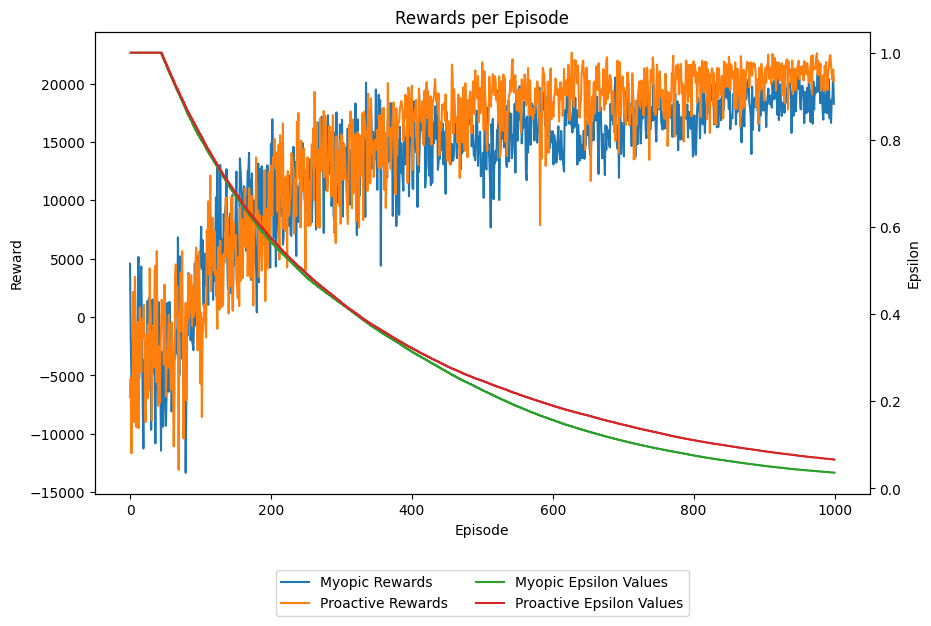

In [9]:
# extract the good rewards from the good_rewards_myopic and good_rewards_proactive
good_rewards_myopic_values = good_rewards_myopic.values()   
good_rewards_proactive_values = good_rewards_proactive.values()

print(good_rewards_myopic_values)

epsilon_values_myopic_values = [epsilon for episode, epsilon in epsilon_values_myopic]
epsilon_values_proactive_values = [epsilon for episode, epsilon in epsilon_values_proactive]

episode_numbers_myopic = [episode for episode, epsilon in epsilon_values_myopic]
episode_numbers_proactive = [episode for episode, epsilon in epsilon_values_proactive]

# Plot the good rewards and epsilon values
plt.figure(figsize=(10, 6))
ax1 = plt.gca()
ax1.plot(good_rewards_myopic_values, label='Myopic Rewards', color='C0')
ax1.plot(good_rewards_proactive_values, label='Proactive Rewards', color='C1')
ax1.set_ylabel('Reward')
ax1.set_xlabel('Episode')
ax1.set_title('Rewards per Episode')

ax2 = ax1.twinx()
ax2.plot(episode_numbers_myopic, epsilon_values_myopic_values, label='Myopic Epsilon Values', color='C2')
ax2.plot(episode_numbers_proactive, epsilon_values_proactive_values, label='Proactive Epsilon Values', color='C3')
ax2.set_ylabel('Epsilon')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

plt.savefig(os.path.join(results_dir, 'plots', 'good_rewards_per_episode_batch.png'))
plt.show()



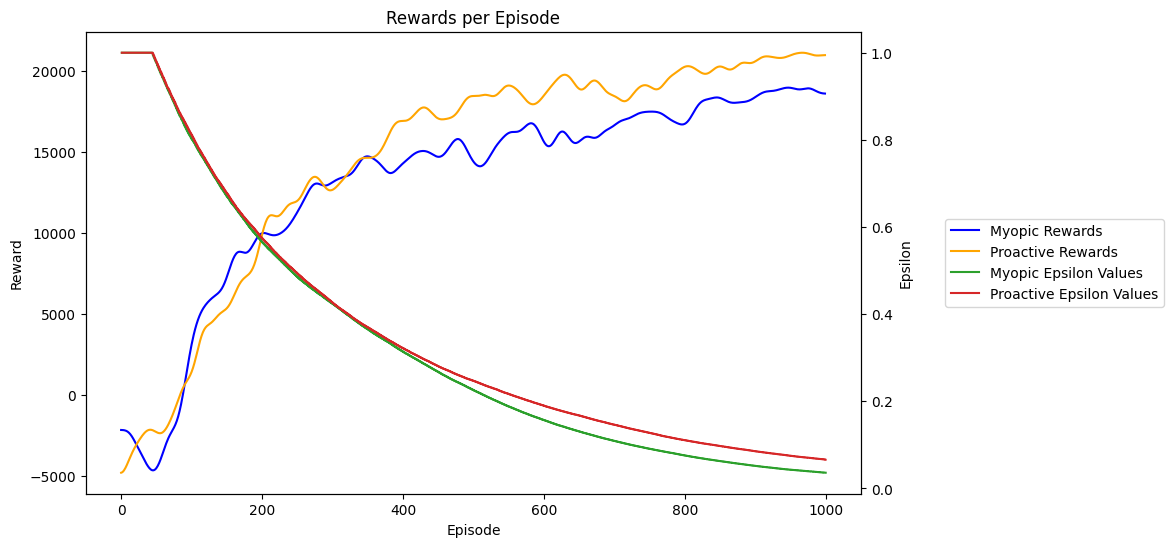

In [10]:
# extract the good rewards from the good_rewards_myopic and good_rewards_proactive
good_rewards_myopic_values = good_rewards_myopic.values()   
good_rewards_proactive_values = good_rewards_proactive.values()

window_size = 20

# # Smooth out the rewards with a window of 100
# window = np.ones(window_size) / window_size
# smoothed_good_rewards_myopic_values = np.convolve(np.array(list(good_rewards_myopic_values)), window, mode='same')
# smoothed_good_rewards_proactive_values = np.convolve(np.array(list(good_rewards_proactive_values)), window, mode='same')

# ==== Gaussian Filter ====
from scipy.ndimage import gaussian_filter1d

smoothed_good_rewards_myopic_values = gaussian_filter1d(np.array(list(good_rewards_myopic_values)), sigma=window_size / 2)
smoothed_good_rewards_proactive_values = gaussian_filter1d(np.array(list(good_rewards_proactive_values)), sigma=window_size / 2)

# # ==== Univariate Spline ====
# from scipy.interpolate import UnivariateSpline

# x_myopic = np.arange(len(good_rewards_myopic_values))
# x_proactive = np.arange(len(good_rewards_proactive_values))

# spline_myopic = UnivariateSpline(x_myopic, list(good_rewards_myopic_values), s=window_size)
# spline_proactive = UnivariateSpline(x_proactive, list(good_rewards_proactive_values), s=window_size)

# smoothed_good_rewards_myopic_values = spline_myopic(x_myopic)
# smoothed_good_rewards_proactive_values = spline_proactive(x_proactive)

# # ==== Savitzky-Golay Filter ====
# from scipy.signal import savgol_filter

# # window_size must be odd and greater than the polynomial order
# polynomial_order = 2
# window_size = max(3, window_size | 1)  # Ensure it's odd
# smoothed_good_rewards_myopic_values = savgol_filter(list(good_rewards_myopic_values), window_size, polynomial_order)
# smoothed_good_rewards_proactive_values = savgol_filter(list(good_rewards_proactive_values), window_size, polynomial_order)


# # ==== Butterworth Filter ====
# from scipy.signal import butter, filtfilt

# # Design a low-pass filter
# b, a = butter(N=2, Wn=0.1)  # Adjust Wn for cutoff frequency
# smoothed_good_rewards_myopic_values = filtfilt(b, a, list(good_rewards_myopic_values))
# smoothed_good_rewards_proactive_values = filtfilt(b, a, list(good_rewards_proactive_values))


# epsilon_values_myopic_values = [epsilon for episode, epsilon in epsilon_values_myopic]
# epsilon_values_proactive_values = [epsilon for episode, epsilon in epsilon_values_proactive]

# episode_numbers_myopic = [episode for episode, epsilon in epsilon_values_myopic]
# episode_numbers_proactive = [episode for episode, epsilon in epsilon_values_proactive]




# Plot the smoothed good rewards and epsilon values
plt.figure(figsize=(10, 6))
ax1 = plt.gca()
ax1.plot(smoothed_good_rewards_myopic_values, label='Myopic Rewards', color='blue')
ax1.plot(smoothed_good_rewards_proactive_values, label='Proactive Rewards', color='orange')
ax1.set_ylabel('Reward')
ax1.set_xlabel('Episode')
ax1.set_title('Rewards per Episode')

ax2 = ax1.twinx()
ax2.plot(episode_numbers_myopic, epsilon_values_myopic_values, label='Myopic Epsilon Values', color='C2')
ax2.plot(episode_numbers_proactive, epsilon_values_proactive_values, label='Proactive Epsilon Values', color='C3')
ax2.set_ylabel('Epsilon')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='center left', bbox_to_anchor=(1.1, 0.5))

plt.savefig(os.path.join(results_dir, 'plots', 'smoothed_good_rewards_per_episode_batch.png'))
plt.show()


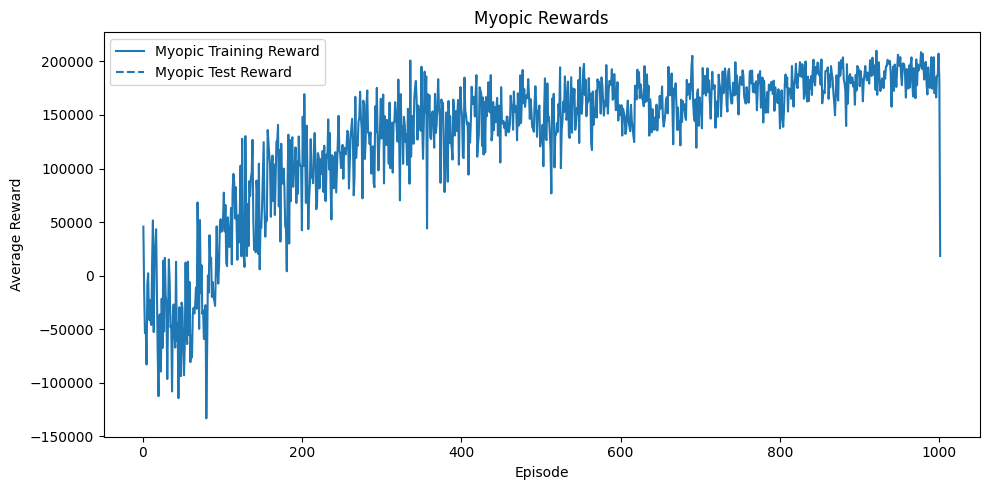

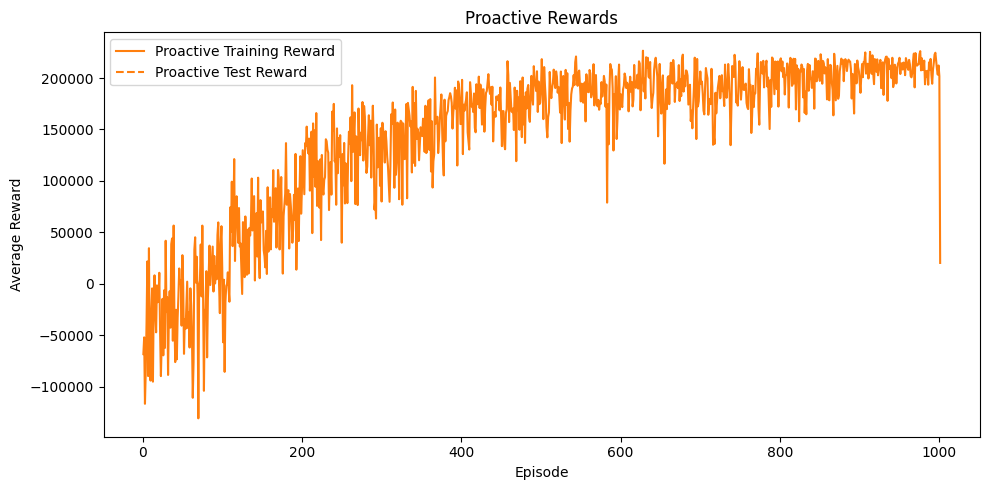

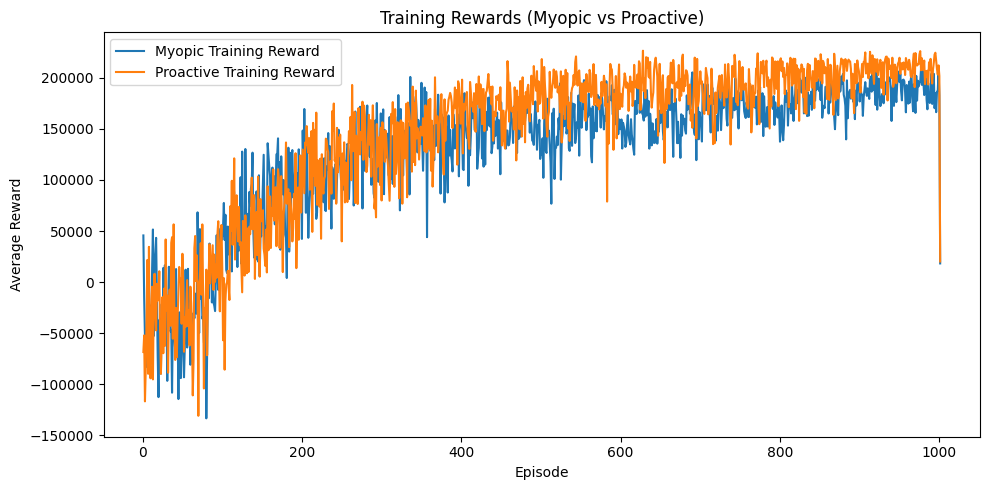

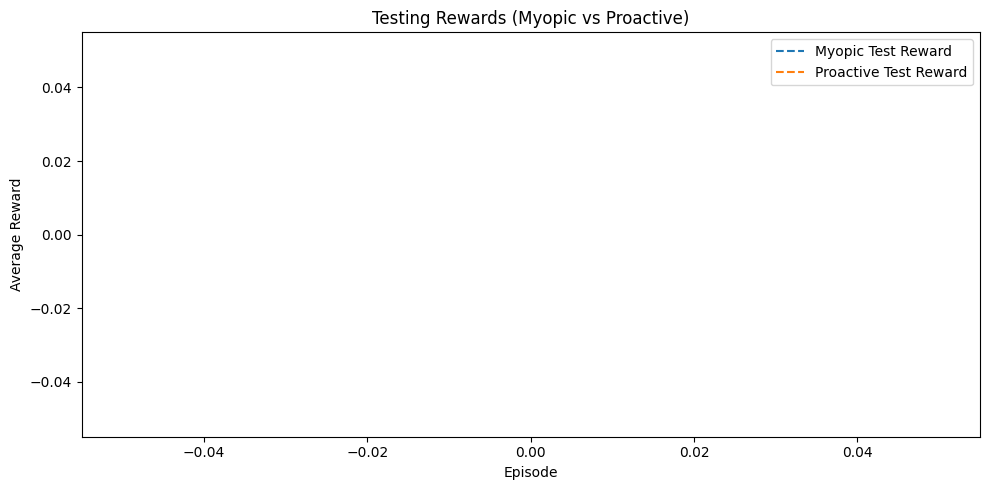

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Process training rewards per episode for myopic
avg_rewards_per_episode_myopic = []
episodes_myopic = []

for episode in sorted(rewards_myopic.keys()):
    # Calculate the total reward across all scenarios for this episode
    total_reward = sum(rewards_myopic[episode].values()) if isinstance(rewards_myopic[episode], dict) else rewards_myopic[episode]
    avg_rewards_per_episode_myopic.append(total_reward)
    episodes_myopic.append(episode + 1)  # Convert 0-based to 1-based indexing

# Process training rewards per episode for proactive
avg_rewards_per_episode_proactive = []
episodes_proactive = []

for episode in sorted(rewards_proactive.keys()):
    # Calculate the total reward across all scenarios for this episode
    total_reward = sum(rewards_proactive[episode].values()) if isinstance(rewards_proactive[episode], dict) else rewards_proactive[episode]
    avg_rewards_per_episode_proactive.append(total_reward)
    episodes_proactive.append(episode + 1)  # Convert 0-based to 1-based indexing

# Extract test rewards for myopic
test_episodes_myopic = [ep + 1 for ep, _ in test_rewards_myopic]  # Add 1 for 1-based indexing
test_avg_rewards_myopic = [reward for _, reward in test_rewards_myopic]

# Extract test rewards for proactive
test_episodes_proactive = [ep + 1 for ep, _ in test_rewards_proactive]
test_avg_rewards_proactive = [reward for _, reward in test_rewards_proactive]

# Plot 1: Myopic (Training and Testing)
plt.figure(figsize=(10, 5))
plt.plot(episodes_myopic, avg_rewards_per_episode_myopic, label='Myopic Training Reward', color='C0')
plt.plot(test_episodes_myopic, test_avg_rewards_myopic, label='Myopic Test Reward', color='C0', linestyle='--')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Myopic Rewards')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'plots', 'myopic_only.png'))
plt.show()

# Plot 2: Proactive (Training and Testing)
plt.figure(figsize=(10, 5))
plt.plot(episodes_proactive, avg_rewards_per_episode_proactive, label='Proactive Training Reward', color='C1')
plt.plot(test_episodes_proactive, test_avg_rewards_proactive, label='Proactive Test Reward', color='C1', linestyle='--')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Proactive Rewards')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'plots', 'proactive_only.png'))
plt.show()

# Plot 3: Training Rewards (Myopic and Proactive)
plt.figure(figsize=(10, 5))
plt.plot(episodes_myopic, avg_rewards_per_episode_myopic, label='Myopic Training Reward', color='C0')
plt.plot(episodes_proactive, avg_rewards_per_episode_proactive, label='Proactive Training Reward', color='C1')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Training Rewards (Myopic vs Proactive)')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'plots', 'training_only.png'))
plt.show()

# Plot 4: Testing Rewards (Myopic and Proactive)
plt.figure(figsize=(10, 5))
plt.plot(test_episodes_myopic, test_avg_rewards_myopic, label='Myopic Test Reward', color='C0', linestyle='--')
plt.plot(test_episodes_proactive, test_avg_rewards_proactive, label='Proactive Test Reward', color='C1', linestyle='--')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Testing Rewards (Myopic vs Proactive)')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'plots', 'testing_only.png'))
plt.show()


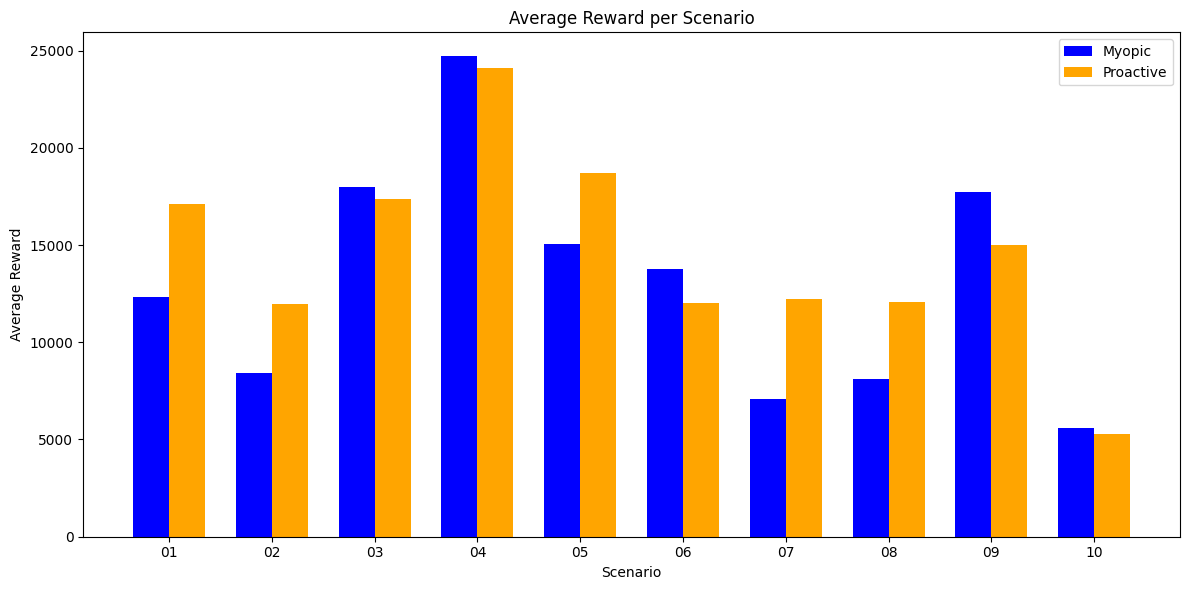

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Initialize dictionaries to store rewards for each scenario
scenario_rewards_myopic = defaultdict(list)
scenario_rewards_proactive = defaultdict(list)

# Group rewards by scenario for the myopic model
for episode, scenarios in rewards_myopic.items():
    if isinstance(scenarios, dict):  # Check if rewards are stored per scenario
        for scenario, reward in scenarios.items():
            scenario_id = scenario[-2:]  # Extract the last two characters of the scenario
            scenario_rewards_myopic[scenario_id].append(reward)

# Group rewards by scenario for the proactive model
for episode, scenarios in rewards_proactive.items():
    if isinstance(scenarios, dict):  # Check if rewards are stored per scenario
        for scenario, reward in scenarios.items():
            scenario_id = scenario[-2:]  # Extract the last two characters of the scenario
            scenario_rewards_proactive[scenario_id].append(reward)

# Calculate the average reward for each scenario for both models
avg_rewards_per_scenario_myopic = {scenario: np.mean(rewards) for scenario, rewards in scenario_rewards_myopic.items()}
avg_rewards_per_scenario_proactive = {scenario: np.mean(rewards) for scenario, rewards in scenario_rewards_proactive.items()}


# Get all unique scenarios
all_scenarios = set(avg_rewards_per_scenario_myopic.keys()).union(avg_rewards_per_scenario_proactive.keys())
sorted_scenarios = sorted(all_scenarios)

# Extract the sorted average rewards for both models
sorted_avg_rewards_myopic = [avg_rewards_per_scenario_myopic.get(scenario, 0) for scenario in sorted_scenarios]
sorted_avg_rewards_proactive = [avg_rewards_per_scenario_proactive.get(scenario, 0) for scenario in sorted_scenarios]

# Plot a grouped bar chart with scenarios on the x-axis and average rewards on the y-axis
x = np.arange(len(sorted_scenarios))  # the label locations
width = 0.35  # the width of the bars

plt.figure(figsize=(12, 6))
plt.bar(x - width / 2, sorted_avg_rewards_myopic, width, label='Myopic', color='blue')
plt.bar(x + width / 2, sorted_avg_rewards_proactive, width, label='Proactive', color='orange')

plt.xlabel('Scenario')
plt.ylabel('Average Reward')
plt.title('Average Reward per Scenario')
plt.xticks(x, sorted_scenarios)
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'plots', 'average_reward_per_scenario.png'))
plt.show()


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Create the new folder within results_dir
scenario_results_dir = os.path.join(results_dir, 'plots', 'reward-plots-per-scenario')
os.makedirs(scenario_results_dir, exist_ok=True)

# Get all unique scenario IDs from both models
all_scenario_ids = set(scenario_rewards_myopic.keys()).union(scenario_rewards_proactive.keys())

# Iterate over all scenarios
for scenario_id in all_scenario_ids:
    # Get rewards lists for both models
    rewards_list_myopic = scenario_rewards_myopic.get(scenario_id, [])
    rewards_list_proactive = scenario_rewards_proactive.get(scenario_id, [])
    
    # Initialize the plot
    plt.figure(figsize=(12, 6))
    
    # Plot for Myopic model
    if rewards_list_myopic:
        window_myopic = min(10, len(rewards_list_myopic))  # Adjust window size as needed
        smoothed_rewards_myopic = np.convolve(rewards_list_myopic, np.ones(window_myopic) / window_myopic, mode='valid')
        plt.plot(range(len(rewards_list_myopic)), rewards_list_myopic, label='Myopic Reward', color='blue', alpha=0.3)
        plt.plot(range(len(smoothed_rewards_myopic)), smoothed_rewards_myopic, label='Myopic Smoothed Reward', color='blue')
    
    # Plot for Proactive model
    if rewards_list_proactive:
        window_proactive = min(10, len(rewards_list_proactive))  # Adjust window size as needed
        smoothed_rewards_proactive = np.convolve(rewards_list_proactive, np.ones(window_proactive) / window_proactive, mode='valid')
        plt.plot(range(len(rewards_list_proactive)), rewards_list_proactive, label='Proactive Reward', color='orange', alpha=0.3)
        plt.plot(range(len(smoothed_rewards_proactive)), smoothed_rewards_proactive, label='Proactive Smoothed Reward', color='orange')
    
    # Set labels and title
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title(f'Reward per Episode for Scenario {scenario_id}')
    plt.legend()
    
    # Save the plot
    plot_filename = f'average_reward_for_scenario_{scenario_id}.png'
    plt.savefig(os.path.join(scenario_results_dir, plot_filename))
    plt.close()


total_timesteps_proactive: 42245
total_timesteps_myopic: 51146


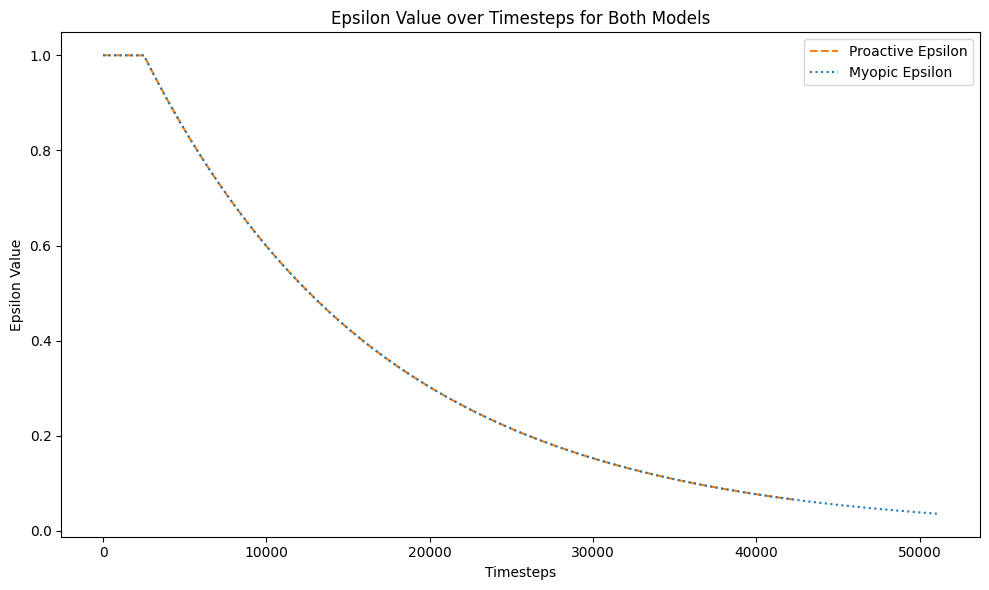

In [14]:
print("total_timesteps_proactive:", total_timesteps_proactive)
print("total_timesteps_myopic:", total_timesteps_myopic)

# Extract epsilon values and their corresponding timesteps
timesteps_myopic = [i for i, _ in enumerate(epsilon_values_myopic)]
epsilon_values_myopic_only = [epsilon for _, epsilon in epsilon_values_myopic]

timesteps_proactive = [i for i, _ in enumerate(epsilon_values_proactive)]
epsilon_values_proactive_only = [epsilon for _, epsilon in epsilon_values_proactive]

# Plot the epsilon values over the episodes for both models
plt.figure(figsize=(10, 6))

# Plot for Proactive model
plt.plot(timesteps_proactive, epsilon_values_proactive_only, label='Proactive Epsilon', color='C1', linestyle='--')
plt.plot(timesteps_myopic, epsilon_values_myopic_only, label='Myopic Epsilon', color='C0', linestyle=':')

plt.xlabel('Timesteps')
plt.ylabel('Epsilon Value')
plt.title('Epsilon Value over Timesteps for Both Models')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'plots', 'epsilon_value_over_timesteps_both_models.png'))
plt.show()

